<a href="https://colab.research.google.com/github/doumoh/RIS_aided_communication/blob/main/OFDM_SIMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna==0.19")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

sionna.config.seed = 42 # Set seed for reproducible random number generation

In [ ]:
!pip uninstall -y sionna tensorflow tensorflow-probability numpy
!pip install sionna==0.19 tensorflow tensorflow-probability numpy --upgrade
!pip uninstall -y mitsuba
!pip install mitsuba==3.5.0

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu

from sionna.channel.tr38901 import Antenna, AntennaArray
from sionna.channel import OFDMChannel
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, RemoveNulledSubcarriers, ResourceGridDemapper
from sionna.utils import BinarySource, ebnodb2no, insert_dims, flatten_last_dims, log10, expand_to_rank
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper
from sionna.utils.metrics import compute_ber
from sionna.utils import sim_ber
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.mimo import StreamManagement

In [76]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/rxx.xml'
# Load scene from drive
scene = load_scene(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, \
                      r_hat, normalize, Camera
from sionna import PI

In [109]:


# Load scene
scene = load_scene(file_path)
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="cross")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[-15,3.5,1.5])

# Add transmitter
scene.add(tx)

width = 8 * scene.wavelength  # Width [m] for 16*16 RIS elements
num_rows = num_cols = int(width/(0.5*scene.wavelength))
ris = RIS(name="ris",
          position=[-5,-3,1.5],
          orientation=[PI/2,0,0],
          num_rows=num_rows,
          num_cols=num_cols)

scene.add(ris)

# Create a receiver
rx = Receiver(name="rx",
              position=[0,2.5,2],
              orientation=[0,0,0])

# Add receiver
scene.add(rx)

In [79]:
from sionna.rt.solver_paths import SolverPaths # Import SolverPaths to modify the _ris_transition_matrices function

class CustomSolverPaths(SolverPaths): # Create new custom solverpaths class
  def _ris_transition_matrices(self, ris_paths, ris_paths_tmp): # Override _ris_transition_matrices
    # Compute Γ(y,z) = sum[sqrt(p_m)A_m e^{jχ_m}] via r() as in nvlabs.github.io/sionna/em_primer.html#reconfigurable-intelligent-surfaces-ris
    sc = [tf.reduce_sum(r(), axis=0) for r in self._scene.ris.values()]
    sc = tf.concat(sc, axis=0)
    sc = sc[tf.newaxis, tf.newaxis, ...]  # Notice we use spatial coef only for sigma_phi_matrix calculation
                                          # For exemple : phase value 180 degree --> Switch ON --> phi_eff = 0 degree


    # Updated coefficient calculation per Equation (17)
    coef = tf.cast(4 * PI, self._rdtype)
    coef /= tf.reduce_prod(ris_paths_tmp.distances, axis=0)
    coef *= tf.cast(tf.sqrt(tx.power_dbm * 0.001 * 120 *PI * 2 * 66 ),self._rdtype)
    coef = tf.complex(coef, tf.cast(0, self._rdtype))  # Ensure coef is complex


    # Define σ_eff
    sigma_eff_value = 0.001  # Scalar value
    sqrt_sigma = tf.sqrt(tf.cast(sigma_eff_value, self._rdtype))
    sqrt_sigma = tf.complex(sqrt_sigma, tf.cast(0, self._rdtype))  # Ensure sqrt_sigma is complex

    # Create phase matrix: 300° for complex elements (Switch ON), 0° for real (Switch OFF)
    imag_part = tf.math.imag(sc)
    phase_deg = tf.where(
        tf.not_equal(imag_part, 0.0),  # Condition for complex numbers
        0.0,  # Phase for complex elements
        165.0     # Phase for real elements (sqrt(phi_eff))
    )
    phase_rad = phase_deg * (np.pi / 180.0)  # Convert to radians
    phase_rad = tf.cast(phase_rad, self._rdtype)  # Ensure phase_rad is the correct dtype

    # Create sigma_phi_matrix with same dimensions as sc
    sigma_phi_matrix = sqrt_sigma * tf.exp(
        tf.complex(0.0, phase_rad)  # Ensure exp result is complex
    )



    # Apply multiplication
    coef *= sigma_phi_matrix

    # Mask invalid paths
    coef = tf.where(ris_paths.mask, coef, tf.cast(0, coef.dtype))

    # Create polarization-preserving transition matrices
    coef = coef[..., tf.newaxis, tf.newaxis]
    ris_mat_t = coef * tf.eye(2, batch_shape=[1, 1, 1], dtype=self._dtype)

    return ris_mat_t

In [80]:
scene._solver_paths = CustomSolverPaths(scene) # Replace to custom SolverPaths

In [81]:
# SNR range for evaluation and training
ebno_db_min = -5.0
ebno_db_max = 10.0

## OFDM configuration
subcarrier_spacing = 30e3 # Hz
fft_size = 128 # Number of subcarriers
num_ofdm_symbols = 14 # Number of OFDM symbols
dc_null = True # Null the DC subcarrier
num_guard_carriers = [5, 6] # Number of guard carriers on each side
pilot_pattern = "kronecker" # Pilot pattern
pilot_ofdm_symbol_indices = [2, 11] # Index of OFDM symbols carrying pilots
cyclic_prefix_length = 0 # Simulation in frequency domain.

## Modulation and coding configuration
num_bits_per_symbol = 2 # QPSK
coderate = 0.5 # Coderate for LDPC code

## Neural receiver configuration
num_conv_channels = 12 # Number of convolutional channels for the convolutional layers forming the neural receiver

## Training configuration
training_batch_size = 48 # Training batch size
model_weights_path = "neural_receiver_weights" # Location to save the neural receiver weights once training is done

In [82]:
stream_manager = StreamManagement(np.array([[1]]), # Receiver-transmitter association matrix
                                  1)               # One stream per transmitter
resource_grid = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                             fft_size = fft_size,
                             subcarrier_spacing = subcarrier_spacing,
                             num_tx = 1,
                             num_streams_per_tx = 1,
                             cyclic_prefix_length = cyclic_prefix_length,
                             dc_null = dc_null,
                             pilot_pattern = pilot_pattern,
                             pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                             num_guard_carriers = num_guard_carriers)

In [83]:
# Codeword length. It is calculated from the total number of databits carried by the resource grid, and the number of bits transmitted per resource element
n = int(resource_grid.num_data_symbols*num_bits_per_symbol)
# Number of information bits per codeword
k = int(n*coderate)

In [95]:
class ResidualBlock(Layer):

    def build(self, input_shape):

        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = Conv2D(filters=num_conv_channels,
                              kernel_size=[2,2],
                              padding='same',
                              activation=None)
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = Conv2D(filters=num_conv_channels,
                              kernel_size=[2,2],
                              padding='same',
                              activation=None)

    def call(self, inputs):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z)
        z = z + inputs

        return z

class NeuralReceiver(Layer):

    def build(self, input_shape):

        # Input convolution
        self._input_conv = Conv2D(filters=num_conv_channels,
                                  kernel_size=[2,2],
                                  padding='same',
                                  activation=None)
        # Residual blocks
        self._res_block_1 = ResidualBlock()
        self._res_block_2 = ResidualBlock()
        self._res_block_3 = ResidualBlock()
        self._res_block_4 = ResidualBlock()
        # Output conv
        self._output_conv = Conv2D(filters=num_bits_per_symbol,
                                   kernel_size=[2,2],
                                   padding='same',
                                   activation=None)

    def call(self, inputs):
        y, no = inputs

        # Feeding the noise power in log10 scale
        no = log10(no)
        # Stacking the real and imaginary components of the different antennas along the 'channel' dimension
        y = tf.transpose(y, [0, 2, 3, 1]) # Putting antenna dimension last
        no = insert_dims(no, 3, 1)
        no = tf.tile(no, [1, y.shape[1], y.shape[2], 1])
        z = tf.concat([tf.math.real(y),
                       tf.math.imag(y),
                       no], axis=-1)
        # Input conv
        z = self._input_conv(z)
        # Residual blocks
        z = self._res_block_1(z)
        z = self._res_block_2(z)
        z = self._res_block_3(z)
        z = self._res_block_4(z)
        # Output conv
        z = self._output_conv(z)

        return z

In [110]:
paths = scene.compute_paths(max_depth=5,
                            num_samples=1e6)

a, tau = paths.cir()
# Compute frequencies of subcarriers and center around carrier frequency
frequencies = subcarrier_frequencies(fft_size, subcarrier_spacing)

# Compute the frequency response of the channel at frequencies.
h_freq = cir_to_ofdm_channel(frequencies,
                             a,
                             tau,
                             normalize=True)


In [86]:
class E2ESystem(Model):


    def __init__(self, system, training=False):
        super().__init__()
        self._system = system
        self._training = training

        ######################################
        ## Transmitter
        self._binary_source = BinarySource()
        if not training:
            self._encoder = LDPC5GEncoder(k, n)
        self._mapper = Mapper("qam", num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(resource_grid)
        ######################################
        ## Channel
        self._channel = ApplyOFDMChannel(add_awgn=True)
        ######################################
        ## Receiver
        if system == "neural-receiver": # Neural receiver
            self._neural_receiver = NeuralReceiver()
            self._rg_demapper = ResourceGridDemapper(resource_grid, stream_manager)
        if not training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    @tf.function
    def call(self, batch_size, ebno_db):

        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        if self._training:
            c = self._binary_source([batch_size, 1, 1, n])
        else:
            b = self._binary_source([batch_size, 1, 1, k])
            c = self._encoder(b)
        # Modulation
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)
        no_ = expand_to_rank(no, tf.rank(x_rg))
        # channel
        y   = self._channel([x_rg,h_freq, no_])
        if self._system == "neural-receiver":
            # The neural receiver computes LLRs from the frequency domain received symbols and N0
            y = tf.squeeze(y, axis=1)
            llr = self._neural_receiver([y, no])
            llr = insert_dims(llr, 2, 1) # Reshape the input to fit what the resource grid demapper is expected
            llr = self._rg_demapper(llr) # Extract data-carrying resource elements. The other LLrs are discarded
            llr = tf.reshape(llr, [batch_size, 1, 1, n]) # Reshape the LLRs to fit what the outer decoder is expected
        if self._training:
            # Compute and return BMD rate (in bit), which is known to be an achievable
            # information rate for BICM systems.
            # Training aims at maximizing the BMD rate
            bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
            bce = tf.reduce_mean(bce)
            rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
            return rate
        else:
            # Outer decoding
            b_hat = self._decoder(llr)
            return b,b_hat # for BER/BLER computation

In [12]:
num_training_iterations = 300 # Number of training iterations

In [ ]:
training = True
if training:
    model = E2ESystem('neural-receiver', training=True)

    optimizer = tf.keras.optimizers.Adam()

    for i in range(num_training_iterations):
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        with tf.GradientTape() as tape:
            rate = model(training_batch_size, ebno_db)
            loss = -rate
            print(loss.numpy())

        # Computing and applying gradients
        weights = model.trainable_weights
        grads = tape.gradient(loss, weights)
        optimizer.apply_gradients(zip(grads, weights))
        if i % 100 == 0:
            print('Iteration {}/{}  Rate: {:.4f} bit'.format(i, num_training_iterations, rate.numpy()), end='\r')



# **loss** **=** **-0.82** **after training**

In [57]:
def save_weights(model, model_weights_path):
    weights = model.get_weights()
    with open(model_weights_path, 'wb') as f:
        pickle.dump(weights, f)

In [58]:
save_weights(model, model_weights_path)

In [59]:
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     1) # Step

In [60]:
# function to load and set weights of a model
def load_weights(model, model_weights_path):
    model(1, tf.constant(10.0, tf.float32))
    with open(model_weights_path, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)

In [115]:
model_conventional = E2ESystem('neural-receiver', training=False)
load_weights(model_conventional, model_weights_path)
_,bler = sim_ber(model_conventional, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000)


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.7522e-01 | 1.0000e+00 |      392297 |     1425408 |         1024 |        1024 |        25.1 |reached target block errors
     -4.0 | 2.4681e-01 | 1.0000e+00 |      351799 |     1425408 |         1024 |        1024 |        21.3 |reached target block errors
     -3.0 | 2.0587e-01 | 1.0000e+00 |      293445 |     1425408 |         1024 |        1024 |        20.0 |reached target block errors
     -2.0 | 9.0391e-02 | 9.3750e-01 |      144949 |     1603584 |         1080 |        1152 |        29.7 |reached target block errors
     -1.0 | 8.1492e-06 | 1.0547e-03 |        1452 |   178176000 |          135 |      128000 |      2135.3 |reached max iter       
      0.0 | 0.0000e+00 | 0.0000e+00 |           0 |   178176000 |    

In [20]:
from google.colab import files
uploaded = files.upload()
from PIL import Image
import numpy as np
img = Image.open("example.png").convert("L")
img_array = np.array(img)
img_bin = np.unpackbits(img_array.flatten())


Saving example.png to example.png


In [96]:
binary_source = BinarySource()
mapper = Mapper("qam", num_bits_per_symbol)
rg_mapper = ResourceGridMapper(resource_grid)
neural_receiver = model_conventional._neural_receiver
rg_demapper = ResourceGridDemapper(resource_grid, stream_manager)

In [111]:
import numpy as np
from PIL import Image
import sionna as sn
import tensorflow as tf

# Step 1: Load and prepare image
img = Image.open("example.png").convert("L").resize((256, 256))  # Resize for consistency
img_array = np.array(img)
img_bin = np.unpackbits(img_array.flatten())

# Step 2: Padding
mod_order = 2
rem = (-len(img_bin)) % mod_order
img_bin_padded = np.concatenate([img_bin, np.zeros(rem, dtype=np.uint8)])
block_length = len(img_bin_padded)

# Step 3: Reshape
BATCH_SIZE = 1
batch_size = 188
bits = tf.convert_to_tensor(img_bin_padded.reshape((BATCH_SIZE, block_length)), dtype=tf.float32)

# Step 4: Build System
NUM_BITS_PER_SYMBOL = mod_order
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
mapper = sn.mapping.Mapper(constellation=constellation)
demapper = sn.mapping.Demapper("app", constellation=constellation)
awgn_channel = sn.channel.AWGN()

# Step 5: Run
ebno_db = tf.fill([batch_size], 10.0)
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)

n = 2784
batch_size = 524288 // n  # 188
usable_bits = batch_size * n  # 523392

# 3. Reshape and convert to tensor
img_bin_trimmed = img_bin_padded[:523392]
bits = tf.convert_to_tensor(img_bin_trimmed.reshape((188, 1, 1, 2784)), dtype=tf.float32)
bits = tf.reshape(bits, (batch_size, 1, 1, n))

x = mapper(bits)
x_rg = rg_mapper(x)
print("x_rg shape: ", x_rg.shape)
print("h_freq shape: ", h_freq.shape)

no_ = expand_to_rank(no, tf.rank(x_rg))
print("no shape: ", no.shape)
print("no_ shape: ", no_.shape)
# Apply channel
y = channel([x_rg, h_freq, no])
print("y shape: ", y.shape)
######################################
## Receiver
# The neural receiver computes LLRs from the frequency domain received symbols and N0
y = tf.squeeze(y, axis=1)
print("y squeze: ", y.shape)
llr = neural_receiver([y, no])
print("llr shape: ", llr.shape)
# Reshape the input to fit what the resource grid demapper is expected
llr = insert_dims(llr, 2, 1)
print("llr insert: ", llr.shape)
# Extract data-carrying resource elements. The other LLRs are discarded
llr = rg_demapper(llr)
print("llr after dem: ", llr.shape)
llr = tf.reshape(llr, [batch_size, 1, 1, n])
print("Post RG-demapper LLRs: ", llr.shape)

# Step 6: Recover bits and image
received_bits = tf.round(tf.sigmoid(llr)).numpy().astype(np.uint8).flatten()
received_bits = received_bits[:len(img_bin)]  # Remove padding
# Ensure we have exactly 524288 bits for a 256x256 image
required_bits = 256 * 256 * 8  # = 524288
received_bits = received_bits[:required_bits]  # Trim if too long
if len(received_bits) < required_bits:
    pad_len = required_bits - len(received_bits)
    received_bits = np.concatenate([received_bits, np.zeros(pad_len, dtype=np.uint8)])

rec_img_array = np.packbits(received_bits).reshape(img_array.shape)
rec_img = Image.fromarray(rec_img_array, mode="L")

x_rg shape:  (188, 1, 1, 14, 128)
h_freq shape:  (1, 1, 2, 1, 1, 1, 128)
no shape:  (188,)
no_ shape:  (188, 1, 1, 1, 1)
y shape:  (188, 1, 2, 14, 128)
y squeze:  (188, 2, 14, 128)
z shape (188, 14, 128, 5)
llr shape:  (188, 14, 128, 2)
llr insert:  (188, 1, 1, 14, 128, 2)
llr after dem:  (188, 1, 1, 1392, 2)
Post RG-demapper LLRs:  (188, 1, 1, 2784)


In [112]:
batch_size = 1
ebno_db = tf.fill([batch_size], 10.0)
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
## Transmitter
# Generate codewords
c = binary_source([batch_size, 1, 1, n])
print("c shape: ", c.shape)
# Map bits to QAM symbols
x = mapper(c)
print("x shape: ", x.shape)
# Map the QAM symbols to a resource grid
x_rg = rg_mapper(x)
print("x_rg shape: ", x_rg.shape)
print("h_freq shape: ", h_freq.shape)
######################################
## Channel
no_ = expand_to_rank(no, tf.rank(x_rg))
print("no shape: ", no.shape)
print("no_ shape: ", no_.shape)
# Apply channel
channel = ApplyOFDMChannel(add_awgn=True)
y = channel([x_rg, h_freq, no])
print("y shape: ", y.shape)
######################################
## Receiver
y = tf.squeeze(y, axis=1)
print("y squeze: ", y.shape)
llr = neural_receiver([y, no])
print("llr shape: ", llr.shape)
# Reshape the input to fit what the resource grid demapper is expected
llr = insert_dims(llr, 2, 1)
print("llr insert: ", llr.shape)
# Extract data-carrying resource elements. The other LLRs are discarded
llr = rg_demapper(llr)
print("llr after dem: ", llr.shape)
llr = tf.reshape(llr, [batch_size, 1, 1, n])
print("Post RG-demapper LLRs: ", llr.shape)

c shape:  (1, 1, 1, 2784)
x shape:  (1, 1, 1, 1392)
x_rg shape:  (1, 1, 1, 14, 128)
h_freq shape:  (1, 1, 2, 1, 1, 1, 128)
no shape:  (1,)
no_ shape:  (1, 1, 1, 1, 1)
y shape:  (1, 1, 2, 14, 128)
y squeze:  (1, 2, 14, 128)
z shape (1, 14, 128, 5)
llr shape:  (1, 14, 128, 2)
llr insert:  (1, 1, 1, 14, 128, 2)
llr after dem:  (1, 1, 1, 1392, 2)
Post RG-demapper LLRs:  (1, 1, 1, 2784)


In [113]:
llr_np = llr.numpy().flatten() # llrs flatten

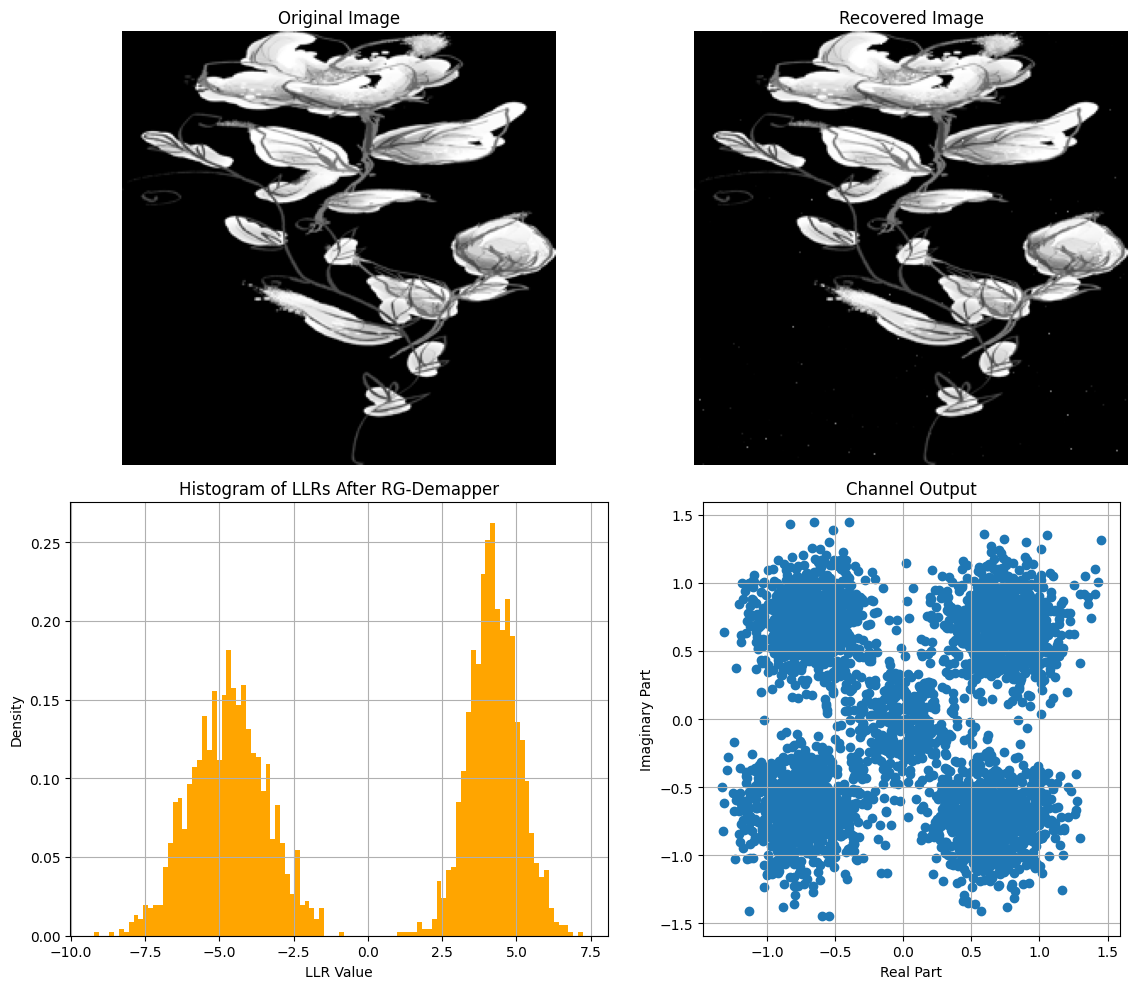

In [114]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1: Original Image
axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].axis('off')
axs[0, 0].set_title("Original Image")

# Subplot 2: Recovered Image
axs[0, 1].imshow(rec_img, cmap='gray')
axs[0, 1].axis('off')
axs[0, 1].set_title("Recovered Image")

# Subplot 3: Histogram of LLRs
axs[1, 0].hist(llr_np, bins=100, density=True, alpha=1, color='orange')
axs[1, 0].grid(True)
axs[1, 0].set_title('Histogram of LLRs After RG-Demapper')
axs[1, 0].set_xlabel('LLR Value')
axs[1, 0].set_ylabel('Density')

# Subplot 4: Channel Output
axs[1, 1].scatter(tf.math.real(y), tf.math.imag(y))
axs[1, 1].set_aspect(1)
axs[1, 1].grid(True)
axs[1, 1].set_title('Channel Output')
axs[1, 1].set_xlabel('Real Part')
axs[1, 1].set_ylabel('Imaginary Part')

plt.tight_layout()
plt.show()
